# Calculate Video Score

I calculate a score for each video based on the number of views it gets in combination of the expected number of views based on the channel size and its frequency of uploads.

In [4]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## 1 Performance Score

### 1.1 Database Query

For each video I query the channel history and query the number of followers plus the number of videos in the last year (if the channel alreasy existed then).

In [2]:
df = pd.read_parquet('smda/project/data/random_50000_thumbnails.parquet')
df = df[df['thumbnail_status'] == 'success']
df = df[df['categories'] != 'Music']

In [3]:
conn = sqlite3.connect('smda/project/data/videos.db')

def get_channel_history(channel_id, date):
    year_ago = pd.to_datetime(date) - pd.DateOffset(months=6)
    
    query = f"""
    SELECT 
        MAX(subs) AS subs,
        SUM(delta_videos) AS delta_videos,
        COUNT(*) AS num_rows
    FROM channel_timeseries
    WHERE channel = '{channel_id}'
    AND datetime >= '{year_ago.strftime('%Y-%m-%d')}'
    AND datetime <= '{date}'
    """
    df_channel = pd.read_sql_query(query, conn)
    
    if df_channel.empty:
        print(f"No data found for channel {channel_id} in the specified date range.")
        return df_channel
    
    # Check for None or NaN before calculation
    delta_videos = df_channel['delta_videos'].iloc[0]
    num_rows = df_channel['num_rows'].iloc[0]
    if num_rows != 26:
        if pd.notnull(delta_videos) and num_rows != 0:
            df_channel['delta_videos'] = delta_videos / num_rows * 26
        else:
            df_channel['delta_videos'] = None
    
    return df_channel

for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing videos"):
    channel_id = row['channel_id']
    date = row['upload_date']
    
    df_channel = get_channel_history(channel_id, date)
    
    if not df_channel.empty:
        df.at[index, 'subs'] = df_channel['subs'].iloc[0]
        df.at[index, 'delta_videos'] = df_channel['delta_videos'].iloc[0]
    else:
        df.at[index, 'subs'] = None
        df.at[index, 'delta_videos'] = None
        
df.to_parquet('smda/project/data/random_50000_thumbnails_with_scores.parquet', index=False)
conn.close()

Processing videos: 100%|██████████| 37383/37383 [01:21<00:00, 455.96it/s]


### 1.2 Calculate Score

Create linear regression model to predict the number of expected views of a video.

In [39]:
# log transform subs and view_count
df['log_subs'] = df['subs'].apply(lambda x: np.log(x) if x > 0 else 0)
df['log_view_count'] = df['view_count'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [52]:
# create a linear regression model with subs and delte_videos as features and predicting view_count
model = LinearRegression()
df_reg = df.dropna(subset=['log_subs', 'delta_videos', 'log_view_count']).copy()

X = df_reg[['log_subs', 'delta_videos']]
y = df_reg['log_view_count']

model.fit(X, y)
df_reg['expected_view_count_log'] = model.predict(X)
df_reg['expected_view_count'] = 10 ** df_reg['expected_view_count_log']

df_reg['view_count_difference_total'] = df_reg['view_count'] - df_reg['expected_view_count']

df_reg['view_count_difference_relative'] = df_reg['view_count_difference_total'] / np.minimum(df_reg['view_count'], df_reg['expected_view_count'])

df_reg['performance_score'] = np.arcsinh(df_reg['view_count_difference_relative'])

df_reg.to_parquet('smda/project/data/random_50000_scores_performance.parquet', index=False)

In [22]:
df_reg

,display_id,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,...,thumbnail_status,subs,delta_videos,log_subs,log_view_count,expected_view_count_log,expected_view_count,view_count_difference_total,view_count_difference_relative,performance_score
1,xTDVWRSmwZM,Gaming,UCYVinkwSX7szARULgYpvhLw,2019-11-11,KINO DER UNTOTEN REMASTERED GAMEPLAY! (BO3 Zom...,1878.0,2265,28276.0,"black ops 3,black ops 3 zombies nacht der unto...",🔫 Pistol + Knife *ONLY* CHALLENGE! 🔪 - Nacht D...,...,success,8.839899e+06,123.000000,15.994786,14.402278,12.212962,201382.533814,1.596783e+06,0.888007,0.799926
2,m4upkcabhog,Travel & Events,UCm23p6UpTcByr980IuiXf7g,2019-11-02,🌟⭐️ WATCH LATEST DISNEY VIDEO: http://vid.io/x...,6.0,594,225.0,"lightcycle,shanghai disney resort,tron,shangha...",[HD] FULL POV TRON Lightcycle Power Run | Tour...,...,success,2.705637e+04,35.360000,10.205678,9.700575,10.895471,53931.576486,-3.760458e+04,-2.303214,-1.571559
4,ezYjJlL0IgU,News & Politics,UC9k-yiEpRHMNVOnOi_aQK8w,2019-11-02,More from Inside Edition: https://www.youtube....,210.0,67,3053.0,"memphis nail salon,denies,rose nails memphis,p...",Nail Salon Owner Denies He Charges Overweight ...,...,success,8.120147e+05,2409.333333,13.607274,12.653115,11.399563,89282.664481,2.234533e+05,0.714511,0.664514
5,RM-i7-elgJQ,Entertainment,UCv61IAZLDELwk2Kk5hfX0mg,2019-11-01,Join me on this adventure as I am hiking in th...,60.0,371,2716.0,"adventure,nature,searching,collecting,collect,...",I Found A New Cave!,...,success,7.296245e+05,120.000000,13.500285,11.253675,11.641219,113688.645379,-3.652565e+04,-0.473357,-0.457256
7,gRggH5N2dPY,Gaming,UCOA1yrrvuBsl0ifIioiTNXQ,2019-11-20,Let's Play Prophesy of Pendor 3.8.4 - The Moun...,5.0,997,458.0,"TAGS:,Prophesy,of,Pendor,Prophecy,Mount,And,Bl...",Let's Play Prophesy of Pendor 3.8.4 Gameplay -...,...,success,1.544383e+05,377.000000,11.947550,9.577065,11.255230,77283.051494,-6.285305e+04,-4.355721,-2.177561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,OdMI4toX6T4,Sports,UCBYTRSUlPMoyFp-gJ_6D7yw,2019-11-23,First time out squirrel hunting for the 2017 y...,269.0,420,540.0,"squirrel hunting,squirrel hunting with 22lr,sq...",Squirrel Hunting With .22lr | Iscope Kill Foo...,...,success,1.738484e+03,29.851852,7.460769,11.601303,10.266591,28755.705321,8.048429e+04,0.736766,0.682526
49994,sv7u6kT1l2Y,Entertainment,UCaWd5_7JhbQBe4dknZhsHJg,2019-11-14,Top 10 Celebrities We Hope Make a Comeback Soo...,145.0,599,3857.0,"top 10,list,viral,top 5,WM,celebrity,celebriti...",Top 10 Celebrities We Hope Make a Comeback Soon,...,success,1.396809e+07,775.047619,16.452286,12.382732,12.242068,207330.211296,3.131479e+04,0.131219,0.130845
49995,pEhcB5gmOK0,Gaming,UCI4Ppudb5EGHNpIYQPVpKdw,2019-11-18,Today I'll show you an exceptionally cool tric...,123.0,323,4193.0,"minecraft add blocks,minecraft how to add bloc...",Minecraft - DESIGN your own Blocks In-Game,...,success,1.254499e+05,10.000000,11.739662,11.798255,11.250226,76897.273912,5.612273e+04,0.421912,0.410302
49998,AqFV0aAtl44,Gaming,UCnc5XTTC_sA5yXD_6hIeFmw,2019-11-15,There are a ton of questions people have regar...,9.0,380,647.0,"Nintendo Switch Launch,Captain Nintendo Dude,T...",Nintendo Switch Launch: Q and A with TriForce,...,success,4.214815e+03,54.000000,8.346361,9.750336,10.466886,35132.653356,-1.797265e+04,-1.047357,-0.914467


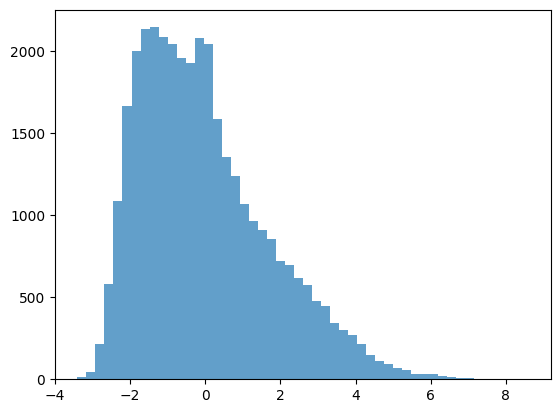

In [55]:
plt.hist(df_reg['performance_score'].dropna(), bins=50, alpha=0.7)
plt.show()

## 2 Quality Score

In [3]:
df_quality = pd.read_parquet('smda/project/data/random_50000_scores_performance.parquet')

In [ ]:
# remove where like and dislike count is less than 1
df_quality = df_quality[(df_quality['like_count'] > 0) & (df_quality['dislike_count'] > 0)].copy()

# log transform like_count and dislike_count with offset to avoid log(0)
df_quality['log_like_count'] = df_quality['like_count'].apply(lambda x: np.log(x))
df_quality['log_dislike_count'] = df_quality['dislike_count'].apply(lambda x: np.log(x))

df_quality = df_quality.dropna(subset=['log_view_count', 'log_like_count', 'log_dislike_count']).copy()

# get expected like and dislike counts based on views
model_like = LinearRegression()
model_dislike = LinearRegression()

X = df_quality[['log_view_count']]
y_like = df_quality['log_like_count']
y_dislike = df_quality['log_dislike_count']

model_like.fit(X, y_like)
model_dislike.fit(X, y_dislike)

df_quality['expected_log_like_count'] = model_like.predict(X)
df_quality['expected_log_dislike_count'] = model_dislike.predict(X)

df_quality['expected_like_count'] = np.exp(df_quality['expected_log_like_count'])
df_quality['expected_dislike_count'] = np.exp(df_quality['expected_log_dislike_count'])

df_quality['like_count_difference_absolute'] = df_quality['like_count'] - df_quality['expected_like_count']
df_quality['dislike_count_difference_absolute'] = df_quality['dislike_count'] - df_quality['expected_dislike_count']

df_quality['like_count_difference_relative'] = df_quality['like_count_difference_absolute'] / np.minimum(df_quality['like_count'], df_quality['expected_like_count'])
df_quality['dislike_count_difference_relative'] = df_quality['dislike_count_difference_absolute'] / np.minimum(df_quality['dislike_count'], df_quality['expected_dislike_count'])

df_quality['quality_difference'] = df_quality['like_count_difference_relative'] - df_quality['dislike_count_difference_relative']

df_quality['quality_score'] = np.arcsinh(df_quality['quality_difference'])

df_quality.to_parquet('smda/project/data/random_50000_scores_quality.parquet', index=False)


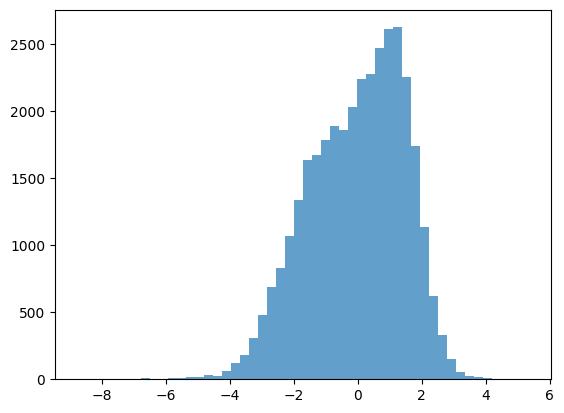

In [7]:
plt.hist(df_quality['quality_score'].dropna(), bins=50, alpha=0.7)
plt.show()

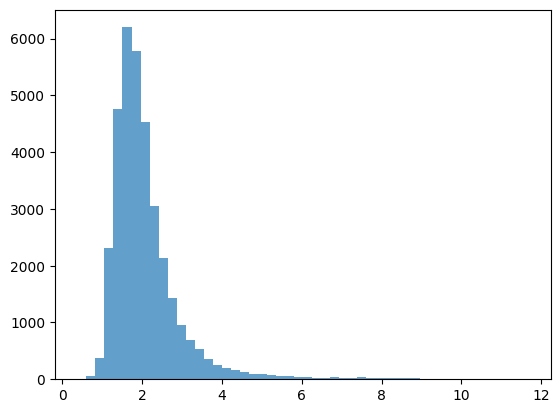

In [42]:
plt.hist(df_quality['like_dislike_ratio'].dropna(), bins=50, alpha=0.7)
plt.show()

## Visualizations

In [2]:
df = pd.read_parquet('smda/project/data/random_50000_scores_quality.parquet')

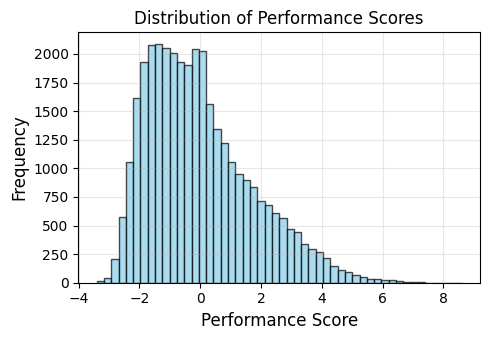

In [15]:
plt.figure(figsize=(5, 3.5))
plt.hist(df['performance_score'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Performance Scores')
plt.xlabel('Performance Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

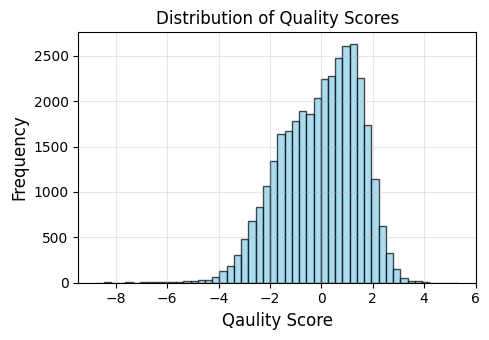

In [16]:
plt.figure(figsize=(5, 3.5))
plt.hist(df['quality_score'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Quality Scores')
plt.xlabel('Qaulity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()